# Project2 Sentiment Classification in Political Tweets 

Our goal is to build an classification model based on the labeled dataset from some source.

#### 1 Specification:
    1. The training data can be downloaded from the link below (it is posted under Homework of Resources). The excel file has two sheets, one for Obama and one for Romney. the label of 2 means mixed opinion, i.e., some part is positive and some part is negative. In the final testing, the test file will only have tweets of three classes, -1, 0, 1. There are some annotations in the data, e.g., <e></e>. You can remove these tags. The tags are for more fine-grained analysis of opinions, but we do not do that in this project.  
#### 2 Requirement
    2,1. Your section number (1 for 12:30pm section and 2 for 3:30pm section) and your group members' names.
    2,2. Preprocessing done to the original text data.
    2,3. Classification algorithms experimented with.  
    2,4. Results in precision, recall, and F score for each class (positive, negative, and neutral) and accuracy for each dataset based on 10-fold cross validation. Discuss which pre-processing or classification algorithm gives the best results. 
#### 3 Updated Requirement
1. Presentation 2: April 25. same rule and requirement as the first presentation apply. The second person in each group should do the presentation this time. You are required to show the new things that you have done since the first presentation and compare the new result with the old one given in the first presentation. 
2. Demo or testing: This will happen on Friday, May 3 in the afternoon. Detailed instructions will come later. 
3. Project report.  Each group is required to write a report about what you have done for project 2. The deadline is Sunday, May 5. The report in pdf should be no more than 5 pages long (single space, 12pt font). It should have the following sections:

#### 4 Abstract
    4,1. Introduction
    4,2. Techniques (including data pre-processing, features used, classification methods tried).
    4,3. Evaluation (results from different methods that you have tried)
    4,4. Conclusion
    4,4. References
####  Import necessary modules

In [179]:
import pandas as pd
import numpy as np
import os
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

import nltk
import string
import matplotlib.pyplot as plotter
import matplotlib.pyplot as plt

from collections import Counter
from time import time

# Part1 Train and Tune our machine learning model
## 1.1 Data collection and selection/slicing
read_excel() will be used to read data from given .xls file and also do some selecting and slicing to the dataframe to get our target columns. Slicing Steps:
1. rename "Unnamed: 3' to 'labels' 
2. select rows whose labels is in [-1, 0, 1]

In [204]:
# for training prediction model
labels = [-1, 0, 1]
# for store our tuned estimators and corresponding accuracy
obama_estimators = {}
romney_estimators = {}

In [205]:
def is_valid_sheetname(sheetName):
    return sheetName == "Obama" or sheetName == "Romney"

def read_from_excel(filepath, sheetName):
    """
        args:
            filepath(str): the path of the raw data
        returns:
            pandas.DataFrame: a DataFrame object
    """
    if is_valid_sheetname(sheetName):
        df = pd.read_excel(filepath, sheet_name = sheetName)
        return df
    else:
        print("Wrong Inputs!")
        exit(1)

def select_data(df, labels):
    """
    """
    df = df.iloc[:,2:4]
    df.rename(columns={'Anootated tweet':'text','Unnamed: 3':'labels'}, inplace=True)
    df = df.iloc[1:,:]
    df = df[df['labels'].isin(labels)]
    # object -> int
    df['labels'] = df['labels'].apply(int)
    # transform all blank rows into np.nan
    df['text'].replace('', np.nan, inplace=True)
    # remove all nan row in dataframe
    df.dropna(subset=['text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [206]:
filepath = "inputs/trainingObamaRomneytweets.xlsx"
df1 = read_from_excel(filepath, "Obama")
df2 = read_from_excel(filepath, "Romney")
Obama = select_data(df1, labels)
Romney = select_data(df2, labels)
print(Obama.head(2))
print(Obama.dtypes, Obama.shape) #(5470, 2)

                                                text  labels
0  Kirkpatrick, who wore a baseball cap embroider...       0
1  #<e>obama</e> debates that Cracker Ass Cracker...       1
text      object
labels     int64
dtype: object (5470, 2)


In [207]:
print(Obama.shape, Obama.dtypes)
print(Romney.shape, Romney.dtypes)

(5470, 2) text      object
labels     int64
dtype: object
(5648, 2) text      object
labels     int64
dtype: object


## 1.2 Data Visualization and conclusion
1. Plot the distribution of pie charts

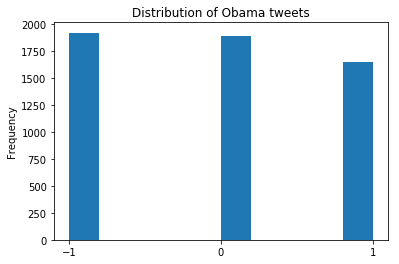

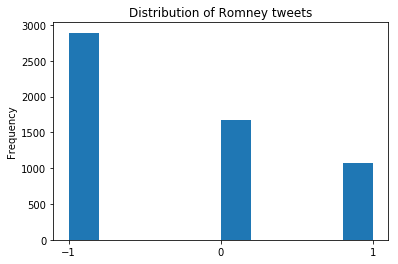

In [208]:
Obama['labels'].plot(kind='hist', xticks=[-1, 0, 1], title='Distribution of Obama tweets')
plt.show()
Romney['labels'].plot(kind='hist', xticks=[-1, 0, 1], title='Distribution of Romney tweets')
plt.show()

Distribution of the tweets:


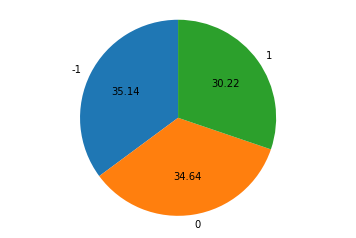

Distribution of the tweets:


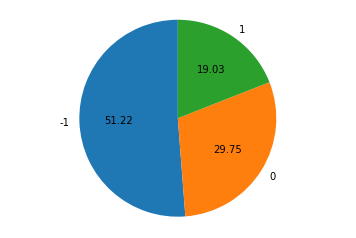

In [209]:
def plotPie(df, ylabels):
    values = list(df['labels'].value_counts())
    figureObj, axesObj = plotter.subplots()

    print("Distribution of the tweets:")
    axesObj.pie(values, labels = ylabels, autopct = '%1.2f', startangle = 90)
    axesObj.axis('equal')

    plotter.show()
#     figureObj.savefig('Distribution_Obama.png', dpi=300)
plotPie(Obama, labels)
plotPie(Romney, labels)

## 1.3 Text Preprocessing

You first task to fill in the following function which processes raw text. The generated requirements are:
1. Handle xmlTags like <e> </e> <a> </a>
2. Handle lowercase(), optional
3. Handle punctuation. Punctuations should be handled as follows: (a) Apostrophe of the form `'s` must be ignored. e.g., `She's` becomes `she`. (b) Other apostrophes should be omitted. e.g, `don't` becomes `dont`. (c) Words must be broken at the hyphen and other punctuations. 
4. Handle tokenization, optional
5. Handle lemmatization
6. Other special handlings.

In [210]:
def handle_xmlTags(text):
    # remove meaningless strings: <e> </e> <a> </a>
    res = text.replace('<e>','').replace('</e>','').replace('<a>','').replace('</a>','')
    return res

def handle_lowercase(text):
    return text.lower()

def handle_punctuation(text):
    """
    """
    text1 = text.replace("'s", "").replace("'", "")
    for ch in text1:
        if ch in string.punctuation:
            text1 = text1.replace(ch, " ")
    return text1

def handle_tokenization(text):
    """
    """
    return nltk.word_tokenize(text)

def handle_lemmatize(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text(str): text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): lemmatized text
    """
    words = []
    tmptext1 = handle_lowercase(text)
    tmptext2 = handle_punctuation(tmptext1)
    tmptext3 = handle_tokenization(tmptext2)
    
    pos_tags = nltk.pos_tag(tmptext3)
    
    for word, tag in pos_tags:
        if tag in tag_map.keys():
            new_tag = tag_map[tag]
            if new_tag:
                w = lemmatizer.lemmatize(word, pos=new_tag)
                words.append(w)
    return words

In [211]:
def handle_specials(df, colName='text'):
    
    # remove meaningless strings: <e> </e> <a> </a>
    df[colName] = df[colName].apply(handle_xmlTags)
    
    # remove website names
    df[colName] = df[colName].apply(lambda x: re.sub(r"((www\.[^\s]+)|(https?://[^\s]+))", "", x))
    # remove words starting with '@'
    df[colName] = df[colName].apply(lambda x: re.sub(r"@\w+", "", x)) #w.o this, acc decrease
    # remove words starting with '#'
#     df[colName] = df[colName].apply(lambda x: re.sub(r"#", "", x))  # with #, acc increase
    # remove all digits
    df[colName] = df[colName].apply(lambda x: re.sub("\d+", "", x))
    
    return(df)

In [212]:
def process_all(df, colName='text'):
    """
    """
    newColName = 'tidy' + colName
    df[newColName] = df[colName].apply(str)
    
    df = handle_specials(df, newColName)   # after switch sequence, acc increase
    
    df[newColName] = df[newColName].apply(handle_xmlTags)
    df[newColName] = df[newColName].apply(handle_punctuation)
    df[newColName] = df[newColName].apply(handle_lowercase)
#     df = handle_specials(df, newColName)
    
    return df

In [213]:
Obama = process_all(Obama)
Obama.head()

,text,labels,tidytext
0,"Kirkpatrick, who wore a baseball cap embroider...",0,kirkpatrick who wore a baseball cap embroider...
1,#<e>obama</e> debates that Cracker Ass Cracker...,1,obama debates that cracker ass cracker tonigh...
2,@Hollivan @hereistheanswer Youre missing the ...,0,youre missing the point im afraid you do n...
3,I was raised as a Democrat left the party yea...,-1,i was raised as a democrat left the party yea...
4,The <e>Obama camp</e> can't afford to lower ex...,0,the obama camp cant afford to lower expectatio...


In [214]:
Romney = process_all(Romney)
Romney.head()

,text,labels,tidytext
0,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1,insidious mitt romney bain helped philip morri...
1,.@WardBrenda @shortwave8669 @allanbourdius you...,-1,you mean like romney cheated in primary
2,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1,mitt romney still doesnt believe that we have ...
3,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1,romney tax plan deserves a nd look because he ...
4,Hope <e>Romney</e> debate prepped w/ the same ...,1,hope romney debate prepped w the same people ...


## 1.4 Tune better parameter for our best classifier from Phase1.
The best classifier from Phase1 is linearSVC(). But we are not sure what's the best parameter yet.
In Phase2, our main goal is to tune a better parameter for transformer() and classifier()
1. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) is the tool to tune the parameters
2. [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and here is an example on how to use pipeline to tune a classifier for documentation classification. [Doc Classfication Example](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py)
3. [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) parameters are very important. Please refer to the documentation and figure out which parameter to tune in our classifier. Keep in mind that the time is very expensive to tune lots of parameters together. There could be tons of combination fits to compare.
4. We will manually tune the parameters, thus we use a global dict to store our tuned estimator(GridSearchCV object) and accuracy scores)

In [215]:
def learn_SVC_classifier(df, pipeline, parameters, kfold):
    """
    """
    # #############################################################################
    X_train, X_test, y_train, y_test = train_test_split(df['tidytext'], df['labels'].values, test_size=0.2)

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=kfold,
                               n_jobs=-1, verbose=1, scoring='accuracy')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    print("Detailed classification report: \n")
    y_true, y_pred = y_test, grid_search.predict(X_test)
    
    print(classification_report(y_true, y_pred))
    print()
    total_accuracy = accuracy_score(y_true, y_pred)
    print("The total accuracy is: %.2f" % total_accuracy)
    
    return grid_search, total_accuracy

### 1.4.1 Use CountVectorizer and TfidfTransformer to get text features

In [216]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(use_idf=True, norm='l2')),
    ('clf', svm.SVC(C=1, gamma=1e-3, kernel='linear'))
])
# Set the parameters by cross-validation  
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
#     'vect__max_df': (0.5, 0.75, 1.0),  # after tuned, 1.0 is better
#     'vect__max_features': (None, 5000, 10000, 50000), # better not tuned, use default
    'vect__ngram_range': ((1,1), (1, 2)),  # unigrams or bigrams, after tuned, (1,2) is better
#     'tfidf__use_idf': (True, False),   # after tuned, True is better
#     'tfidf__norm': ('l1', 'l2'),    # after tuned, 'l2' is better
#     'clf__kernel': ('rbf', 'linear', 'poly', 'sigmoid'),  #after tuned, 'linear' is better
#     'clf__gamma': (1e-3, 1e-4),  # after tuned, 1e-3 is better
#     'clf__C': (1, 10, 100, 1000), # after tuned, 1 is better
#     'clf__max_iter': (10, 50, 80), # better not tuned, use default
}
t0o_grid_search, t0o_tot_acc = learn_SVC_classifier(Obama, pipeline, parameters, 10)
obama_estimators[t0o_grid_search] = t0o_tot_acc

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.7s finished


done in 39.647s

Best score: 0.594
Best parameters set:
	vect__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.62      0.73      0.67       418
           0       0.58      0.50      0.53       352
           1       0.68      0.64      0.66       324

   micro avg       0.63      0.63      0.63      1094
   macro avg       0.63      0.62      0.62      1094
weighted avg       0.63      0.63      0.62      1094


The total accuracy is: 0.63


In [217]:
# We get the best estimator from grid_search
t0r_grid_search, t0r_tot_acc = learn_SVC_classifier(Romney, pipeline, parameters, 10)
romney_estimators[t0r_grid_search] = t0r_tot_acc

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   37.9s finished


done in 42.159s

Best score: 0.606
Best parameters set:
	vect__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.59      0.85      0.69       566
           0       0.47      0.24      0.32       345
           1       0.61      0.38      0.47       219

   micro avg       0.57      0.57      0.57      1130
   macro avg       0.56      0.49      0.49      1130
weighted avg       0.56      0.57      0.54      1130


The total accuracy is: 0.57


### 1.4.2* Use TfidfVectorizer() to get text features
While using CountVectorizer() and TfidfTransformer() combination to extract features, we could also use TfidfVectorizer() directly to extract our text features from raw text information.
1. without stopwords
2. with stopwords to further reduce "cursive" dimensionality

#### 1.4.2.1 Without stopwords

In [116]:
t2_tvec = TfidfVectorizer(norm='l2', max_df=1.0, use_idf=True)
t2_svc = svm.SVC(C=1, gamma=1e-3, kernel='linear')
t2_pipeline = Pipeline([
    ('tvec',t2_tvec),
    ('clf', t2_svc),
])
# Set the parameters by cross-validation  
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
t2_parameters = {
#     'tvec__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'tvec__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
#     'tvec__norm': ('l1', 'l2'),
#     'tvec__use_idf': (True, False)
}
t2o_grid_srch, t2o_tot_acc = learn_SVC_classifier(Obama, t2_pipeline, t2_parameters, 10)
obama_estimators[t2o_grid_srch] = t2o_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2))}
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   34.9s finished


done in 38.710s

Best score: 0.601
Best parameters set:
	tvec__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.59      0.71      0.64       380
           0       0.61      0.51      0.56       394
           1       0.64      0.61      0.62       320

   micro avg       0.61      0.61      0.61      1094
   macro avg       0.61      0.61      0.61      1094
weighted avg       0.61      0.61      0.61      1094


The total accuracy is: 0.61


In [219]:
t2r_grid_srch, t2r_tot_acc = learn_SVC_classifier(Romney, t2_pipeline, t2_parameters, 10)
romney_estimators[t2r_grid_srch] = t2r_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2))}
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   39.8s finished


done in 44.063s

Best score: 0.594
Best parameters set:
	tvec__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.64      0.85      0.73       619
           0       0.50      0.27      0.35       336
           1       0.59      0.41      0.48       175

   micro avg       0.61      0.61      0.61      1130
   macro avg       0.57      0.51      0.52      1130
weighted avg       0.59      0.61      0.58      1130


The total accuracy is: 0.61


#### 1.4.2.2 With stopwords

In [220]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# Verify that the following commands work for you, before moving on.

lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dahang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dahang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dahang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dahang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [221]:
from nltk.corpus import wordnet as wn
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)
        'JJ':wn.ADJ, # adjective (yellow)                  
        'JJR':wn.ADJ, # adj., comparative (bigger)          
        'JJS':wn.ADJ, # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':wn.ADJ_SAT, # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':wn.ADJ, # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
    }

In [222]:
stopwords=set(nltk.corpus.stopwords.words('english'))

In [223]:
# tvec = TfidfVectorizer(stop_words=stopwords, max_features=100000, ngram_range=(1, 3))
# t2_tvec = TfidfVectorizer(norm='l2', max_df=1.0, use_idf=True)
t3_tvec = TfidfVectorizer(stop_words=stopwords, norm='l2', max_df=1.0, use_idf=True)
t3_svc = svm.SVC(C=1, gamma=1e-3, kernel='linear')
t3_pipeline = Pipeline([
    ('tvec',t3_tvec),
    ('clf', t3_svc),
])
# Set the parameters by cross-validation  
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
t3_parameters = {
#     'tvec__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'tvec__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams or trigrams
#     'tvec__norm': ('l1', 'l2'),
#     'tvec__use_idf': (True, False)
}
t3o_grid_srch, t3o_tot_acc = learn_SVC_classifier(Obama, t3_pipeline, t3_parameters, 10)
obama_estimators[t3o_grid_srch] = t3o_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.4s finished


done in 45.650s

Best score: 0.579
Best parameters set:
	tvec__ngram_range: (1, 3)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.62      0.64      0.63       381
           0       0.61      0.54      0.57       386
           1       0.61      0.67      0.64       327

   micro avg       0.61      0.61      0.61      1094
   macro avg       0.61      0.62      0.61      1094
weighted avg       0.61      0.61      0.61      1094


The total accuracy is: 0.61


In [224]:
t3r_grid_srch, t3r_tot_acc = learn_SVC_classifier(Romney, t3_pipeline, t3_parameters, 10)
romney_estimators[t3r_grid_srch] = t3r_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.9s finished


done in 48.857s

Best score: 0.583
Best parameters set:
	tvec__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.62      0.83      0.71       579
           0       0.49      0.29      0.36       341
           1       0.56      0.41      0.47       210

   micro avg       0.59      0.59      0.59      1130
   macro avg       0.56      0.51      0.52      1130
weighted avg       0.57      0.59      0.56      1130


The total accuracy is: 0.59


#### 1.4.2.3 stopwords + rarewords

In [225]:
def get_rare_words(processed_tweets, colName='tidytext'):
    """ use the word count information across all tweets in training data to come up with a feature list
    Inputs:
        processed_tweets: pd.DataFrame: the output of process_all() function
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    rare_words = []
    words = []
    for unit in processed_tweets[colName]:
        # pick up those keys whose value <= 1
        words += unit
    rare_words = [ key for key, value in Counter(words).items() if value <= 1]
    rare_words = sorted(rare_words)
    return rare_words

In [226]:
rare_stopwords = set(nltk.corpus.stopwords.words('english') + get_rare_words(Obama))

In [227]:
# tvec = TfidfVectorizer(stop_words=stopwords, max_features=100000, ngram_range=(1, 3))
# t2_tvec = TfidfVectorizer(norm='l2', max_df=1.0, use_idf=True)
t4_tvec = TfidfVectorizer(stop_words=rare_stopwords, norm='l2', max_df=1.0, use_idf=True)
t4_svc = svm.SVC(C=1, gamma=1e-3, kernel='linear')
t4_pipeline = Pipeline([
    ('tvec',t4_tvec),
    ('clf', t4_svc),
])
# Set the parameters by cross-validation  
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
t4_parameters = {
#     'tvec__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'tvec__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams or trigrams
#     'tvec__norm': ('l1', 'l2'),
#     'tvec__use_idf': (True, False)
}
t4o_grid_srch, t4o_tot_acc = learn_SVC_classifier(Obama, t4_pipeline, t4_parameters, 10)
obama_estimators[t4o_grid_srch] = t4o_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.3s finished


done in 44.043s

Best score: 0.589
Best parameters set:
	tvec__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.58      0.65      0.62       367
           0       0.56      0.53      0.55       380
           1       0.68      0.62      0.65       347

   micro avg       0.60      0.60      0.60      1094
   macro avg       0.61      0.60      0.60      1094
weighted avg       0.60      0.60      0.60      1094


The total accuracy is: 0.60


In [228]:
t4r_grid_srch, t4r_tot_acc = learn_SVC_classifier(Romney, t4_pipeline, t4_parameters, 10)
romney_estimators[t4r_grid_srch] = t4r_tot_acc

Performing grid search...
pipeline: ['tvec', 'clf']
parameters:
{'tvec__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.1s finished


done in 50.962s

Best score: 0.586
Best parameters set:
	tvec__ngram_range: (1, 2)
Detailed classification report: 

              precision    recall  f1-score   support

          -1       0.63      0.84      0.72       582
           0       0.50      0.32      0.39       336
           1       0.59      0.41      0.48       212

   micro avg       0.60      0.60      0.60      1130
   macro avg       0.57      0.52      0.53      1130
weighted avg       0.58      0.60      0.58      1130


The total accuracy is: 0.60


## 1.5 Part1 Conclusion
1. Compared with CountVectorizer and TfidfTransformer, it's noticable that using TfidfVectorizer directly without stopwords could directly shorten the computational time, but it could lead to a slightly lower accuracy from 61.3% to 59.4%. The reason could be stopwords helped to reduce some slightly redundant word features.
2. while with stopwords, the time is slightly reduced from without stopwords. But the accuracy is lower more than 3%. We could guess that this dimension reduction is not applicable to our case.

# Part 2 Presentation[Done in class on April 25, 2019]
[ignore]

# Part 3 Demo Session
1. <h3>Test demo format is as below:</h3>
one for Obama, one for Romney
<br>The test dataset are in CSV format with two columns: -
<br>col-1:  Tweet_ID
<br>col-2:  Tweet_Text...

2. <h3>Demo Requirements</h3>
    1. Test data will be sent to you 1hr before the start of your corresponding demo slot. There will be two .csv test files: one for Obama and another for Romney dataset. Each row is one test instance [ just like your training data files (Exactly same format!)]. But, class labels will NOT be provided for demo.
 
    2. You should use the labeled data you already have for training your models (before we send you the test set) and simply apply your BEST trained classifier model on the newly-provided test data. NO cross-validation!! Your classifier will just make one pass over all test instances and predict the class labels (-1/0/1). 

3. <h3>Submission Requirements</h3>
    1. two output files (one for each test set )  [See below for naming convention]
        NO ZIPPING of output files!  ONLY ZIP your source code.
 
        MAIL HEADER:   "Spring 2019 - Project 2 Demo Submission"
 
        The output files should be named as follows:
 
        "FirstName1_Lastname1_FirstName2_Lastname2_Obama.txt"
        "FirstName1_Lastname1_FirstName2_Lastname2_Romney.txt"
 
        Content of each file:   Format: "Tweet_ID;;Predicted Class Label\n"
 
        Example:
 
        1;;1
        2;;-1
        3;;0
        4;;1
        5;;-1
    2. runnable project code with a README (How to setup and run your code) in a zipped folder.

In [163]:
ofpath = 'inputs/Obama.xlsx'
rfpath = 'inputs/Romney.xlsx'
df_obama_t = pd.read_excel(ofpath)
df_romney_t = pd.read_excel(rfpath)

In [164]:
df_obama_t.head()

,Tweet_ID,Tweet_Text,label
0,1,Another <e>Obama</e> Stimulus Failure Battery...,-1
1,2,DukeMaximum this makes <e>Obama</e> look weak...,-1
2,3,<e>Obama</e> <a>lied</a>? What a surprise? RT ...,-1
3,4,@Barack<e>Obama</e>: President Obama: I said I...,1
4,5,If we're going to blame <e>Obama</e> for gas p...,1


In [165]:
df_romney_t.head()

,Tweet_ID,Tweet_Text,label
0,1,<e>Romney</e> gave such a miserable answer on...,-1
1,2,10 Sketchy <a>Investments</a> By Mitt <e>Romn...,-1
2,3,DICK MORRIS: <e>Romney</e> won the second <a...,1
3,4,#<e>Romney</e> Screwing <a>Americans</a> In #OH,-1
4,5,"I wanna hear <e>Romney</e> say ""nigga please ...",0


In [166]:
df_obama_t = process_all(df_obama_t, colName='Tweet_Text')
df_obama_t.head()

,Tweet_ID,Tweet_Text,label,tidyTweet_Text
0,1,Another <e>Obama</e> Stimulus Failure Battery...,-1,another obama stimulus failure battery maker ...
1,2,DukeMaximum this makes <e>Obama</e> look weak...,-1,dukemaximum this makes obama look weak havin...
2,3,<e>Obama</e> <a>lied</a>? What a surprise? RT ...,-1,obama lied what a surprise rt despite obam...
3,4,@Barack<e>Obama</e>: President Obama: I said I...,1,president obama i said i would end the war ...
4,5,If we're going to blame <e>Obama</e> for gas p...,1,if were going to blame obama for gas prices go...


In [167]:
df_romney_t = process_all(df_romney_t, colName='Tweet_Text')
df_romney_t.head()

,Tweet_ID,Tweet_Text,label,tidyTweet_Text
0,1,<e>Romney</e> gave such a miserable answer on...,-1,romney gave such a miserable answer on women ...
1,2,10 Sketchy <a>Investments</a> By Mitt <e>Romn...,-1,sketchy investments by mitt romney
2,3,DICK MORRIS: <e>Romney</e> won the second <a...,1,dick morris romney won the second debate ...
3,4,#<e>Romney</e> Screwing <a>Americans</a> In #OH,-1,romney screwing americans in oh
4,5,"I wanna hear <e>Romney</e> say ""nigga please ...",0,i wanna hear romney say nigga please shut th...


In [168]:
df_obama_t['Predicted Class Label'] = t0o_grid_search.predict(df_obama_t['tidyTweet_Text'])
df_obama_t['Formatted Output'] = [str(x) + ';;' + str(y) for x,y in 
                                  zip(df_obama_t['Tweet_ID'], df_obama_t['Predicted Class Label'])]
df_obama_t.head(20)

,Tweet_ID,Tweet_Text,label,tidyTweet_Text,Predicted Class Label,Formatted Output
0,1,Another <e>Obama</e> Stimulus Failure Battery...,-1,another obama stimulus failure battery maker ...,-1,1;;-1
1,2,DukeMaximum this makes <e>Obama</e> look weak...,-1,dukemaximum this makes obama look weak havin...,-1,2;;-1
2,3,<e>Obama</e> <a>lied</a>? What a surprise? RT ...,-1,obama lied what a surprise rt despite obam...,-1,3;;-1
3,4,@Barack<e>Obama</e>: President Obama: I said I...,1,president obama i said i would end the war ...,1,4;;1
4,5,If we're going to blame <e>Obama</e> for gas p...,1,if were going to blame obama for gas prices go...,1,5;;1
5,6,"<e>Obama</e>, just had an Algore ”bully” momen...",0,obama just had an algore ”bully” moment adva...,0,6;;0
6,7,<e>Obama</e> acts way to white to be considere...,-1,obama acts way to white to be considered the f...,0,7;;0
7,8,<e>Obama</e> is a pansy.,-1,obama is a pansy,1,8;;1
8,9,"Well look at <e>Obama</e> being respectful, in...",1,well look at obama being respectful instead o...,1,9;;1
9,10,How rude of you <e>Obama</e>!,-1,how rude of you obama,-1,10;;-1


In [169]:
df_romney_t['Predicted Class Label'] = t0r_grid_search.predict(df_romney_t['tidyTweet_Text'])
df_romney_t['Formatted Output'] = [str(x) + ';;' + str(y) for x,y in 
                                  zip(df_romney_t['Tweet_ID'], df_romney_t['Predicted Class Label'])]
df_romney_t.head(20)

,Tweet_ID,Tweet_Text,label,tidyTweet_Text,Predicted Class Label,Formatted Output
0,1,<e>Romney</e> gave such a miserable answer on...,-1,romney gave such a miserable answer on women ...,-1,1;;-1
1,2,10 Sketchy <a>Investments</a> By Mitt <e>Romn...,-1,sketchy investments by mitt romney,-1,2;;-1
2,3,DICK MORRIS: <e>Romney</e> won the second <a...,1,dick morris romney won the second debate ...,1,3;;1
3,4,#<e>Romney</e> Screwing <a>Americans</a> In #OH,-1,romney screwing americans in oh,-1,4;;-1
4,5,"I wanna hear <e>Romney</e> say ""nigga please ...",0,i wanna hear romney say nigga please shut th...,-1,5;;-1
5,6,<e>Romney</e> has a plan to help <a>legal Am...,1,romney has a plan to help legal americans o...,1,6;;1
6,7,Everyone must have been high watching the <a>...,1,everyone must have been high watching the deb...,1,7;;1
7,8,After last nights <a>debate</a> I really wann...,-1,after last nights debate i really wanna see h...,-1,8;;-1
8,9,Why <e>Romney</e> won the <a>debate</a> big l...,1,why romney won the debate big last night via...,1,9;;1
9,10,Here's <e>Romney</e>'s First Post-<a>Town Hal...,0,here romney first post town hall ad,0,10;;0


In [171]:
obama_name = 'Obama'
obama_inputfile='inputs/' + obama_name + '.xlsx'
obama_outputfile='outputs/Hang_Yang_Jiashan_Wu_' + obama_name + '.txt'
df_obama_t['Formatted Output'].to_csv(obama_outputfile, header=None, index=None, sep=' ', mode='w')

In [172]:
romney_name = 'Romney'
romney_inputfile='inputs/' + romney_name + '.xlsx'
romney_outputfile='outputs/Hang_Yang_Jiashan_Wu_' + romney_name + '.txt'
df_romney_t['Formatted Output'].to_csv(romney_outputfile, header=None, index=None, sep=' ', mode='w')

In [177]:
def gen_ouput(clf, inputfile, outputfile):
    
    """
    use the best tuned classifier to predict our test data and return the output in txt file
        args:
            clf(classifier): the best classifier we tuned till now
            inputfile(str): the system path of input test data file
            outputfile(str): the system path for output result file
        returns:
            out(txt): output file with column Tweet_ID and predicted label, double semi-colon separated
            Content of each file:   Format: "Tweet_ID;;Predicted Class Label\n"
                Example:
                1;;1
                2;;-1
                3;;0
                4;;1
                5;;-1
    """
    df = pd.read_excel(inputfile)
    df = process_all(df, colName='Tweet_Text')
    new_colname = 'tidy' + 'Tweet_Text'
    df['Predicted Class Label'] = clf.predict(df[new_colname])
    df['Formatted Output'] = [str(x) + ';;' + str(y) for x,y in zip(df['Tweet_ID'], df['Predicted Class Label'])]
#     assert len(df['Tweet_ID']) == len(outdf['Tweet_ID'])
    df['Formatted Output'].to_csv(outputfile, header=None, index=None, sep=' ', mode='w')
    return df

# Final Conslusion
After tuning, we get our best estimator is t0o_grid_search for Obama and t0r_grid_search for Romney. Let's use them to predict our future data.

In [237]:
def best_classifier(clf_dict):
    """
    """
    print('max accuracy is %.3f' % max(clf_dict.values()))
    if len(clf_dict) != 0:
        key = [k for k, v in clf_dict.items() if v == max(clf_dict.values())]
    return key[0]

In [243]:
# how to get teh best classifier we tuned till now, use the dict to sort the highest value we got
obama_best_clf = best_classifier(obama_estimators)
# setup obama input & output
obama_name = 'Obama'
obama_inputfile='inputs/' + obama_name + '.xlsx'
obama_outputfile='outputs/Hang_Yang_Jiashan_Wu_' + obama_name + '.txt'
gen_ouput(obama_best_clf, obama_inputfile, obama_outputfile)

max accuracy is 0.626


,Tweet_ID,Tweet_Text,label,tidyTweet_Text,Predicted Class Label,Formatted Output
0,1,Another <e>Obama</e> Stimulus Failure Battery...,-1,another obama stimulus failure battery maker ...,-1,1;;-1
1,2,DukeMaximum this makes <e>Obama</e> look weak...,-1,dukemaximum this makes obama look weak havin...,-1,2;;-1
2,3,<e>Obama</e> <a>lied</a>? What a surprise? RT ...,-1,obama lied what a surprise rt despite obam...,-1,3;;-1
3,4,@Barack<e>Obama</e>: President Obama: I said I...,1,president obama i said i would end the war ...,1,4;;1
4,5,If we're going to blame <e>Obama</e> for gas p...,1,if were going to blame obama for gas prices go...,1,5;;1
5,6,"<e>Obama</e>, just had an Algore ”bully” momen...",0,obama just had an algore ”bully” moment adva...,0,6;;0
6,7,<e>Obama</e> acts way to white to be considere...,-1,obama acts way to white to be considered the f...,-1,7;;-1
7,8,<e>Obama</e> is a pansy.,-1,obama is a pansy,-1,8;;-1
8,9,"Well look at <e>Obama</e> being respectful, in...",1,well look at obama being respectful instead o...,1,9;;1
9,10,How rude of you <e>Obama</e>!,-1,how rude of you obama,-1,10;;-1


In [241]:
# setup Romney input & output
romney_best_clf = best_classifier(romney_estimators)
romney_name = 'Romney'
romney_inputfile='inputs/' + romney_name + '.xlsx'
romney_outputfile='outputs/Hang_Yang_Jiashan_Wu_' + romney_name + '.txt'
gen_ouput(romney_best_clf, romney_inputfile, romney_outputfile)

max accuracy is 0.609


,Tweet_ID,Tweet_Text,label,tidyTweet_Text,Predicted Class Label,Formatted Output
0,1,<e>Romney</e> gave such a miserable answer on...,-1,romney gave such a miserable answer on women ...,-1,1;;-1
1,2,10 Sketchy <a>Investments</a> By Mitt <e>Romn...,-1,sketchy investments by mitt romney,-1,2;;-1
2,3,DICK MORRIS: <e>Romney</e> won the second <a...,1,dick morris romney won the second debate ...,1,3;;1
3,4,#<e>Romney</e> Screwing <a>Americans</a> In #OH,-1,romney screwing americans in oh,-1,4;;-1
4,5,"I wanna hear <e>Romney</e> say ""nigga please ...",0,i wanna hear romney say nigga please shut th...,-1,5;;-1
5,6,<e>Romney</e> has a plan to help <a>legal Am...,1,romney has a plan to help legal americans o...,1,6;;1
6,7,Everyone must have been high watching the <a>...,1,everyone must have been high watching the deb...,1,7;;1
7,8,After last nights <a>debate</a> I really wann...,-1,after last nights debate i really wanna see h...,-1,8;;-1
8,9,Why <e>Romney</e> won the <a>debate</a> big l...,1,why romney won the debate big last night via...,1,9;;1
9,10,Here's <e>Romney</e>'s First Post-<a>Town Hal...,0,here romney first post town hall ad,0,10;;0
